In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import networkx as nx
from collections import defaultdict
import random
import string

In [5]:
class SymbolicSequence:
    """Symbolic sequence with homotopic transformation operations"""

    def __init__(self, seq="", alphabet=None):
        # Initialization of the alphabet with opposite elements
        if alphabet is None:
            self.create_default_alphabet()
        else:
            self.alphabet = alphabet

        self.sequence = seq
        self.meaning = None  # Semantic meaning of the sequence

    def create_default_alphabet(self):
        """Creates an alphabet with opposite elements"""
        symbols = list(string.ascii_lowercase[:13])  # First half of the alphabet
        opposites = [s + "'" for s in symbols]  # Opposite elements

        self.alphabet = {}
        for s, o in zip(symbols, opposites):
            self.alphabet[s] = o
            self.alphabet[o] = s

    def is_reducible(self):
        """Checks if a reduction can be performed"""
        for i in range(len(self.sequence) - 1):
            if self.alphabet.get(self.sequence[i]) == self.sequence[i+1]:
                return True
        return False

    def reduce_once(self):
        """Performs one reduction, if possible"""
        if not self.is_reducible():
            return False

        for i in range(len(self.sequence) - 1):
            if self.alphabet.get(self.sequence[i]) == self.sequence[i+1]:
                self.sequence = self.sequence[:i] + self.sequence[i+2:]
                return True

        return False

    def homotopic_reduction(self):
        """Full homotopic reduction"""
        while self.reduce_once():
            pass
        return self.sequence

    def __str__(self):
        return self.sequence


class LanguageGame:
    """Simulator of Wittgenstein's language game based on topos of symbolic sequences"""

    def __init__(self, num_agents=5, initial_vocabulary_size=10, max_seq_length=5):
        self.agents = []
        self.global_vocabulary = {}  # Community's shared vocabulary
        self.meaning_space = {}  # Space of meanings
        self.interaction_graph = nx.Graph()  # Graph of interactions between agents
        self.history = []  # History of the language game

        self.create_agents(num_agents)
        self.create_initial_vocabulary(initial_vocabulary_size, max_seq_length)

    def create_agents(self, num_agents):
        """Creates the agents of the language game"""
        for i in range(num_agents):
            agent = {
                'id': i,
                'vocabulary': {},  # Agent's personal vocabulary
                'sequence_factory': SymbolicSequence()  # Sequence factory
            }
            self.agents.append(agent)
            self.interaction_graph.add_node(i)

    def create_initial_vocabulary(self, size, max_length):
        """Creates the initial vocabulary of symbolic sequences"""
        symbols = list(self.agents[0]['sequence_factory'].alphabet.keys())

        # Create a set of original "meanings" (objects or actions)
        meanings = [f"object_{i}" for i in range(size//2)] + [f"action_{i}" for i in range(size//2)]

        for meaning in meanings:
            # Create a random symbolic sequence
            length = random.randint(2, max_length)
            seq = ''.join(random.choice(symbols) for _ in range(length))

            symbol_seq = SymbolicSequence(seq, self.agents[0]['sequence_factory'].alphabet)
            # Reduce the sequence
            reduced_seq = symbol_seq.homotopic_reduction()

            # Add to the global vocabulary
            self.global_vocabulary[reduced_seq] = meaning
            self.meaning_space[meaning] = reduced_seq

            # Distribute words among agents (not everyone knows all words)
            for agent in self.agents:
                if random.random() < 0.7:  # 70% probability of knowing the word
                    agent['vocabulary'][reduced_seq] = meaning

    def run_language_game(self, num_iterations=100):
        """Runs the language game for a given number of iterations"""
        for i in range(num_iterations):
            # Select two random agents to interact
            agent1, agent2 = random.sample(self.agents, 2)

            # Add link to the interaction graph
            self.interaction_graph.add_edge(agent1['id'], agent2['id'])

            # Agent 1 selects a random meaning and corresponding sequence
            if not agent1['vocabulary']:
                continue  # If the vocabulary is empty, skip the iteration

            meaning = random.choice(list(agent1['vocabulary'].values()))
            sequence = None

            # Find the sequence by meaning
            for seq, m in agent1['vocabulary'].items():
                if m == meaning:
                    sequence = seq
                    break

            if not sequence:
                continue

            # Agent 2 tries to understand the message
            understood = False
            if sequence in agent2['vocabulary']:
                understood = True
                # If agent 2 understood the message, the link is strengthened
                self.interaction_graph[agent1['id']][agent2['id']]['weight'] = \
                    self.interaction_graph[agent1['id']][agent2['id']].get('weight', 0) + 1
            else:
                # Agent 2 doesn't know this word, learning occurs
                agent2['vocabulary'][sequence] = meaning

            # Record the result of the interaction
            self.history.append({
                'iteration': i,
                'agent1': agent1['id'],
                'agent2': agent2['id'],
                'sequence': sequence,
                'meaning': meaning,
                'understood': understood
            })

            # With some probability, create a new word (linguistic innovation)
            if random.random() < 0.05:  # 5% probability
                self.create_new_word(agent1)

    def create_new_word(self, agent):
        """Creates a new word through homotopic transformation of an existing one"""
        if not agent['vocabulary']:
            return

        # Select a random word from the agent's vocabulary
        sequence = random.choice(list(agent['vocabulary'].keys()))
        meaning = agent['vocabulary'][sequence]

        # Modify the sequence by adding a pair of opposite elements
        symbols = list(agent['sequence_factory'].alphabet.keys())
        symbol = random.choice(symbols)
        opposite = agent['sequence_factory'].alphabet[symbol]

        # Create a new sequence with a pair of opposite elements
        position = random.randint(0, len(sequence))
        new_seq = sequence[:position] + symbol + opposite + sequence[position:]

        # Create a new meaning related to the old one
        new_meaning = f"{meaning}_variant"

        # Add the new word to the agent's vocabulary
        symbol_seq = SymbolicSequence(new_seq, agent['sequence_factory'].alphabet)
        reduced_seq = symbol_seq.homotopic_reduction()

        # If the reduced sequence already exists, do not add it
        if reduced_seq in agent['vocabulary']:
            return

        agent['vocabulary'][reduced_seq] = new_meaning
        self.global_vocabulary[reduced_seq] = new_meaning
        self.meaning_space[new_meaning] = reduced_seq

    def visualize_language_network(self):
        """Visualizes the network of language meanings and sequences"""
        G = nx.Graph()

        # Add nodes for meanings and sequences
        for meaning, sequence in self.meaning_space.items():
            G.add_node(meaning, type='meaning')
            G.add_node(sequence, type='sequence')
            G.add_edge(meaning, sequence)

        # Add links between sequences based on homotopic proximity
        sequences = list(self.global_vocabulary.keys())
        for i, seq1 in enumerate(sequences):
            for seq2 in sequences[i+1:]:
                # Rough criterion for homotopic proximity: common prefix or suffix
                if (seq1.startswith(seq2) or seq2.startswith(seq1) or
                    seq1.endswith(seq2) or seq2.endswith(seq1)):
                    G.add_edge(seq1, seq2, type='homotopic')

        # Visualization
        plt.figure(figsize=(12, 10), facecolor='white')
        pos = nx.spring_layout(G, k=0.5, iterations=100)

        # Draw meaning nodes
        meanings = [node for node, attrs in G.nodes(data=True)
                if attrs.get('type') == 'meaning']
        nx.draw_networkx_nodes(G, pos, nodelist=meanings,
                            node_color='lightblue', node_size=100)

        # Draw sequence nodes
        sequences = [node for node, attrs in G.nodes(data=True)
                    if attrs.get('type') != 'meaning']
        nx.draw_networkx_nodes(G, pos, nodelist=sequences,
                            node_color='lightgreen', node_size=80)

        # Draw edges
        meaning_edges = [(u, v) for u, v in G.edges()
                        if 'type' not in G[u][v]]
        homotopic_edges = [(u, v) for u, v in G.edges()
                        if G[u][v].get('type') == 'homotopic']

        nx.draw_networkx_edges(G, pos, edgelist=meaning_edges, width=1.5, edge_color='blue')
        nx.draw_networkx_edges(G, pos, edgelist=homotopic_edges,
                            width=1, alpha=0.7, style='dashed', edge_color='red')

        nx.draw_networkx_labels(G, pos, font_size=8)
        
        plt.title("Network of Language Meanings and Symbolic Sequences")
        # plt.tight_layout()
        plt.axis('off')
        return plt

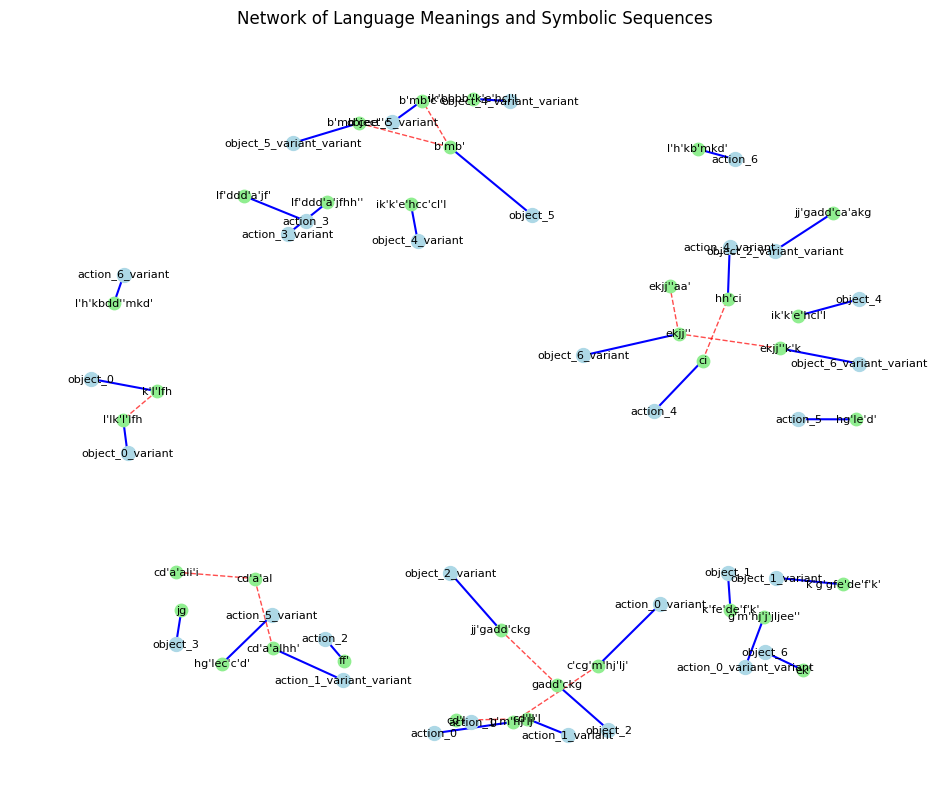

In [6]:
# Example
language_game = LanguageGame(num_agents=7, initial_vocabulary_size=14, max_seq_length=8)
language_game.run_language_game(num_iterations=1000)
network_plot = language_game.visualize_language_network()
network_plot.show()